# Sales forecasting system.
We want to set up our company's warehouse in another location and we need to estimate the rate of sales, which has been increasing since the company's creation, for the next few months in order to provide the space we will need.

## Step 1: Loading the dataset
The dataset can be found in this project folder under the name sales.csv. You can load it into the code directly from the link (https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv) or download it and add it by hand in your repository.

In [29]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'
sales = pd.read_csv(url)

# Convert 'date' column to datetime and set as index
sales['date'] = pd.to_datetime(sales['date'])
sales.set_index('date', inplace=True)

# Resample the data
sales_ts = sales['sales'].resample('D').mean()

## Step 2: Construct and analyze the time serie
Construct the valid data structure for the time serie, graph it, and then analyze it and answer the following questions:

Which is the tensor of the time serie?
Which is the trend?
Is it stationary?
Is there variability or noise?
NOTE: A tensor in a time serie is the minimum unit of time for which there is data. It can be every second, minute, hour, day, week, month...

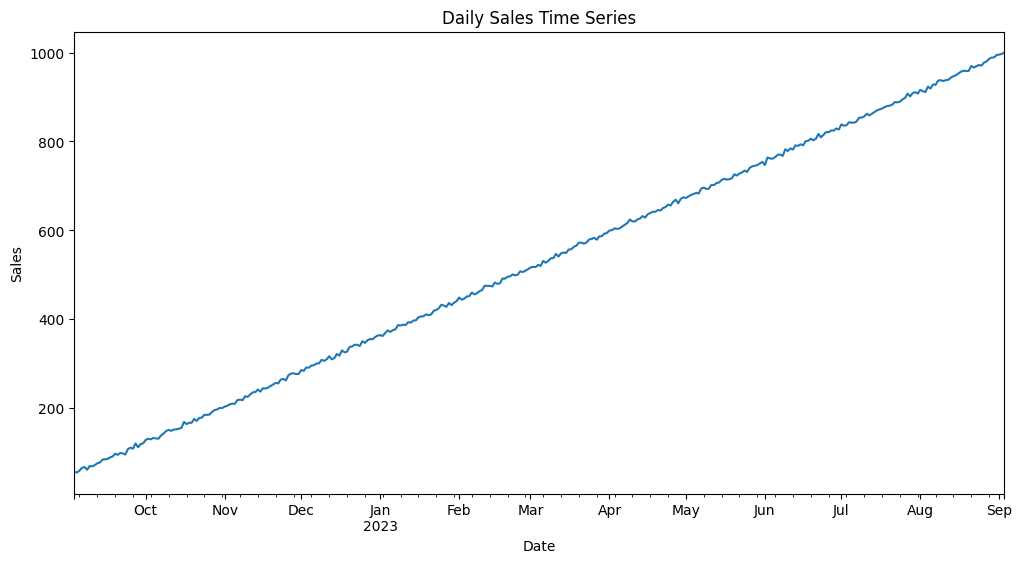

date
2022-09-03    55.292157
2022-09-04    53.803211
2022-09-05    58.141693
2022-09-06    64.530899
2022-09-07    66.013633
Freq: D, Name: sales, dtype: float64
Tensor of the time series: 1 days 00:00:00


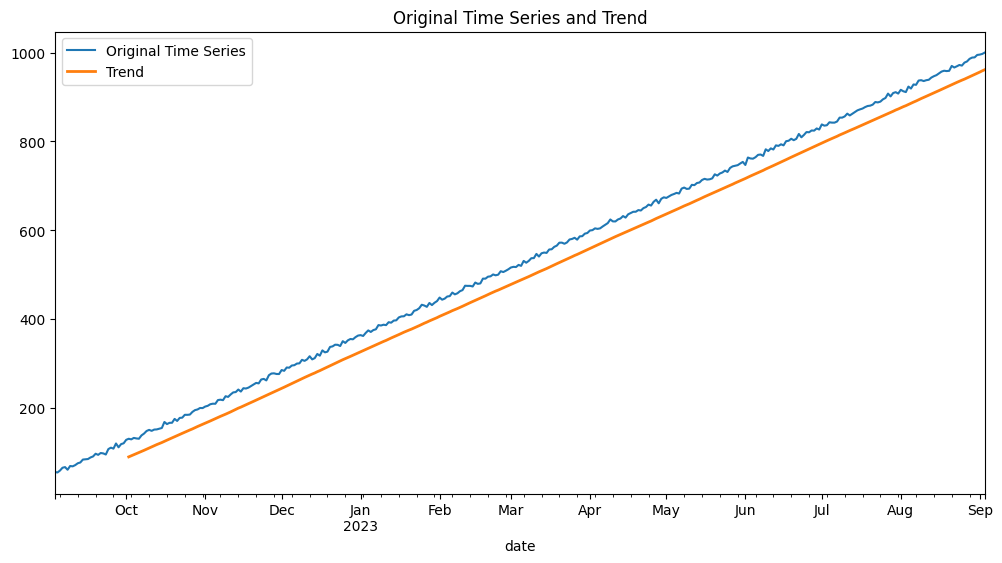


Augmented Dickey-Fuller Test:
ADF Statistic: 0.545414193706381
p-value: 0.9861899815311065
Critical Values: {'1%': -3.4490648539347544, '5%': -2.8697861692116478, '10%': -2.5711631253228306}


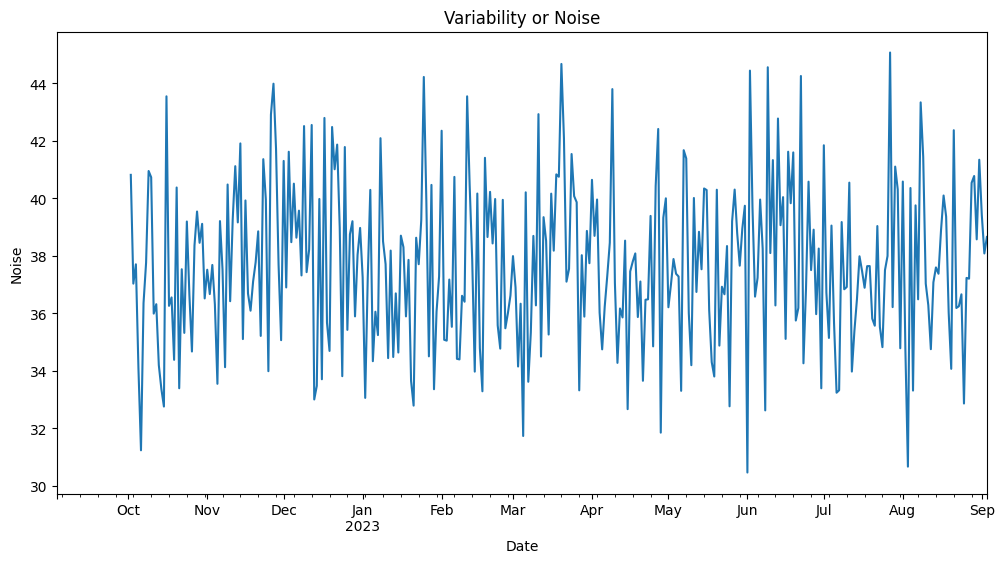

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the time series
sales_ts.plot(figsize=(12, 6), title='Daily Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Print the first few rows of the time series
print(sales_ts.head())

# Calculate the tensor of the time series
tensor = sales_ts.index[1] - sales_ts.index[0]
print(f'Tensor of the time series: {tensor}')

# Calculate the trend using a rolling mean
trend = sales_ts.rolling(window=30).mean()  # You can adjust the window size for a smoother trend
sales_ts.plot(figsize=(12, 6), label='Original Time Series')
trend.plot(label='Trend', linewidth=2)
plt.title('Original Time Series and Trend')
plt.legend()
plt.show()

# Check for stationarity using the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_ts)
print('\nAugmented Dickey-Fuller Test:')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')

# Check for variability or noise
noise = sales_ts - trend
noise.plot(figsize=(12, 6), title='Variability or Noise')
plt.xlabel('Date')
plt.ylabel('Noise')
plt.show()

## Step 3: Train an ARIMA
Use the training data to find the best parameterization of your ARIMA model.

Best ARIMA Model Parameters:
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  292
Model:             SARIMAX(0, 1, 1)x(2, 0, 1, 7)   Log Likelihood                -729.178
Date:                           Sat, 20 Jan 2024   AIC                           1470.355
Time:                                   17:12:23   BIC                           1492.395
Sample:                               09-03-2022   HQIC                          1479.185
                                    - 06-21-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.6274      0.537      6.753      0.000       2.575       4.680
ma.L1         

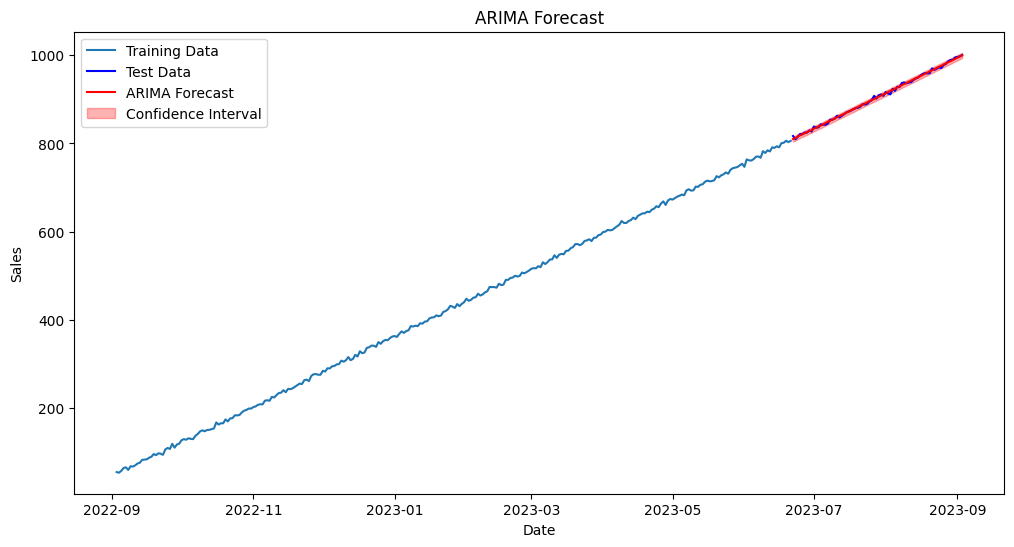

In [31]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_size = int(len(sales_ts) * 0.8)
train, test = sales_ts[:train_size], sales_ts[train_size:]

# Use auto_arima to find the best parameters
model = auto_arima(train, seasonal=True, m=7)  # m is the number of periods per season (daily data, so m=7 for weekly seasonality)

# Print the best model parameters
print("Best ARIMA Model Parameters:")
print(model.summary())

# Fit the ARIMA model
model.fit(train)

# Forecast using the trained ARIMA model
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

# Plot the training data, test data, and forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='blue')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Key elements in the output:

✅Fitted Model (SARIMAX): SARIMAX(0, 1, 1)x(2, 0, 1, 7)

The SARIMAX model consists of two parts: the non-seasonal part (p, d, q) and the seasonal part (P, D, Q, m). In this case:
Non-seasonal component (p, d, q): (0, 1, 1)
Seasonal component (P, D, Q, m): (2, 0, 1, 7)
This means that the model includes an ARIMA component (0, 1, 1) and a seasonal component with a period of 7 days.
Model Coefficients:

✅Intercept: 3.6274. This is the constant term in the model.
ma.L1 (Moving Average component): -0.9842. Coefficient associated with the ARIMA model's moving average component.
ar.S.L7 (Seasonal component): -0.6069. Coefficient associated with the seasonal component with a period of 7 days.
ar.S.L14 (Seasonal component): 0.2116. Coefficient associated with the seasonal component with a period of 14 days.
ma.S.L7 (Seasonal Moving Average component): 0.7658. Coefficient associated with the seasonal moving average component with a period of 7 days.

✅Fit Statistics:

Log Likelihood: -729.178. Indicates the maximum probability of observing the data given the model parameters.
AIC (Akaike Information Criterion): 1470.355. A criterion that penalizes more complex models, seeking a balance between fit and simplicity.
BIC (Bayesian Information Criterion): 1492.395. Similar to AIC but with a stronger penalty for model complexity.
HQIC (Hannan-Quinn Information Criterion): 1479.185. Another information criterion that penalizes model complexity.
Diagnostics and Warnings:

Diagnostic tests such as the Ljung-Box test and Jarque-Bera test are provided. The Ljung-Box test evaluates if the residuals are independent, and the Jarque-Bera test checks the normality of residuals.
Warnings: Certain aspects or limitations of the model are highlighted.

## Step 4: Predict with the test set
Now use the trained model with the test set and compare the points with the real ones. Measure the performance of the time serie.

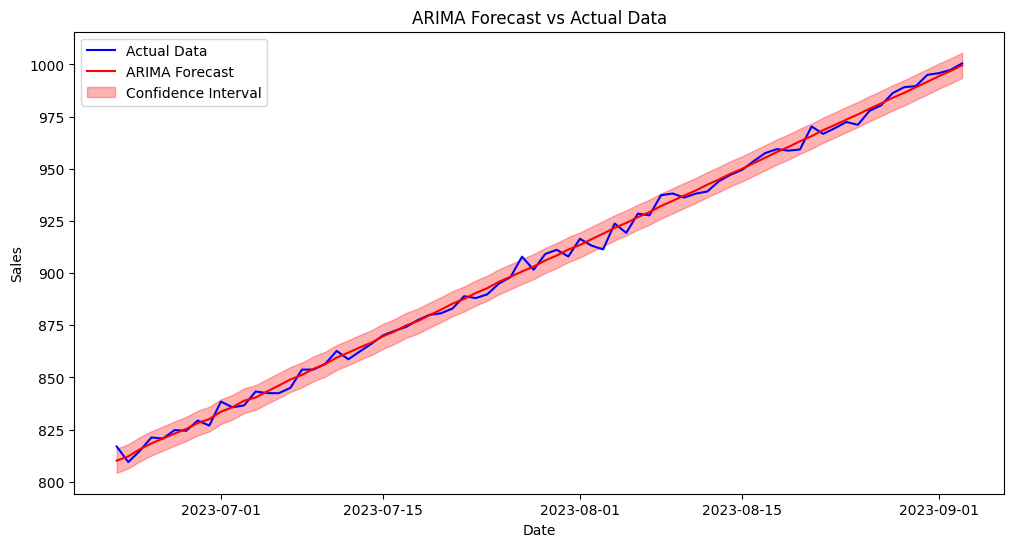

Mean Squared Error (MSE): 7.45
Root Mean Squared Error (RMSE): 2.73
Mean Absolute Error (MAE): 2.16


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Forecast using the trained ARIMA model on the test set
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

# Plot the actual vs predicted values with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual Data', color='blue')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate performance metrics
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')


## Step 5: Save the model
Store the model in the corresponding folder.

In [34]:
import pickle

# Save the ARIMA model to a file

model_filename = "../models/arima_model_train_seasonalTrue_m7.pkl"
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f'The ARIMA model has been saved to {model_filename}')

The ARIMA model has been saved to ../models/arima_model_train_seasonalTrue_m7.pkl
